In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torchvision
import torch.optim as optim
from tqdm import tqdm


data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
#device = torch.device("mps")
device = torch.device("cpu")
print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")
print(device)

# digits: 10; # samples: 1797; # features 64
cpu


In [2]:
#design a torch nn that classifies digits images using conv layers
class ConvNet(nn.Module):
    def __init__(self, n_digits):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, n_digits)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [3]:
def train(model, train_loader):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in tqdm(range(1, 100)):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()


In [4]:
data2 = np.reshape(data, (len(data), 1, 8, 8))
data2.shape

(1797, 1, 8, 8)

In [104]:
from torch.utils.data import DataLoader, TensorDataset
X_train, X_test, y_train, y_test = train_test_split(data2, labels, test_size=0.2, random_state=0)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()), batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()), batch_size=128, shuffle=True, pin_memory=True)

ValueError: Found input variables with inconsistent numbers of samples: [1797, 70000]

In [6]:
import time
model = ConvNet(n_digits).to(device)
start_time = time.time()
#train(model, train_loader)
print(f"--- {time.time() - start_time} seconds ---")

--- 4.029273986816406e-05 seconds ---


In [7]:
model.eval()
pred = model(torch.from_numpy(X_test).float().to(device))
print(f"Accuracy: {metrics.accuracy_score(y_test, pred.argmax(dim=1).cpu().numpy())}")

Accuracy: 0.08611111111111111


[4 2 2 2 2 4 2 2 2 4]


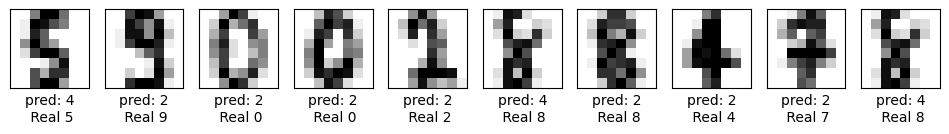

In [8]:
samples = np.random.randint(0, len(X_test), 10)
pred_samples = np.argmax(model(torch.from_numpy(X_test[samples]).float().to(device)).detach().cpu().numpy(), axis = 1)
real_labels = y_test[samples]
print(pred_samples)
sample_images = X_test[samples].reshape(10, 8, 8)
fig, axes = plt.subplots(1, 10, figsize=(12, 6))
for i in range(10):
    axes[i].imshow(sample_images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())
    axes[i].set_xlabel(f"pred: {pred_samples[i]}\n Real {real_labels[i]}")

# Good! Let's try with MNIST database

In [9]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [10]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True, pin_memory=True)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 5),
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.conv(x)

In [12]:
def train(model, train_loader):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(1, n_epochs)):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

In [28]:
model = Net().to(device)
start_time = time.time()
train(model, train_loader)
print(f"--- {time.time() - start_time} seconds ---")
#torch.save(model, "./models/mnist_model.pt")

100%|██████████| 9/9 [06:02<00:00, 40.29s/it]

--- 362.5773754119873 seconds ---


In [14]:
model = torch.load("./models/mnist_model.pt")

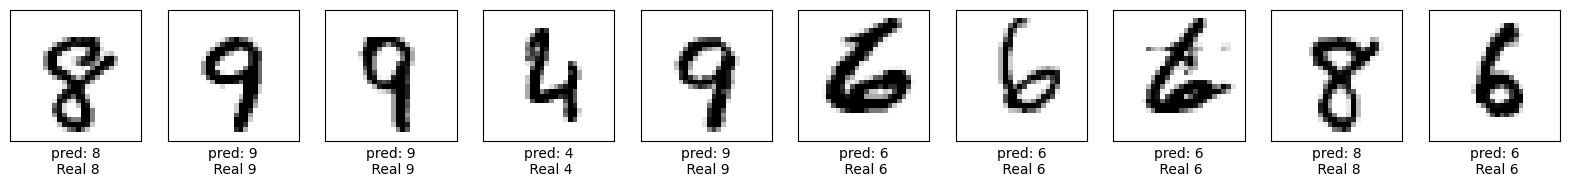

In [15]:
model.eval()
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

samples = np.random.randint(0, len(example_data), 10)
pred_samples = np.argmax(model(example_data[samples].to(device)).detach().cpu().numpy(), axis = 1)
real_targets = example_targets[samples]

sample_images = example_data[samples].reshape(10, 28, 28)
fig, axes = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    axes[i].imshow(sample_images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())
    axes[i].set_xlabel(f"pred: {pred_samples[i]}\n Real {real_targets[i]}")


In [16]:
images = None
labels = None
for img, lab in train_loader:
    if images is None:
        images = np.array(img)
        labels = np.array(lab)
    else:
        images = np.concatenate((images, img), axis = 0)
        labels = np.concatenate((labels, lab), axis = 0)

for img, lab in test_loader:
    if images is None:
        images = np.array(img)
        labels = np.array(lab)
    else:
        images = np.concatenate((images, img), axis = 0)
        labels = np.concatenate((labels, lab), axis = 0)

images = images.reshape(len(images), 28, 28)
images.shape

(70000, 28, 28)

In [17]:
def median_matrix(matrices):
    # Step 1: Flatten each matrix into a vector
    flattened_matrices = [matrix.flatten() for matrix in matrices]

    # Step 2: Stack the flattened matrices
    stacked_matrix = np.column_stack(flattened_matrices)

    # Step 3: Compute the median vector
    median_vector = np.median(stacked_matrix, axis=1)

    # Step 4: Reshape the median vector
    return median_vector.reshape(matrices[0].shape)

In [18]:
med = None
for i in range(10):
    if med is None:
        med = np.array([median_matrix(images[np.where(labels == i)])])
    else:
        med = np.append(med, [median_matrix(images[np.where(labels == i)])], axis = 0)

In [19]:
def thresholding(img, threshold):
    img[img < threshold] = 0
    img[img >= threshold] = 120
    return img

#med = np.array([thresholding(med[i], 0.8) for i in range(10)])


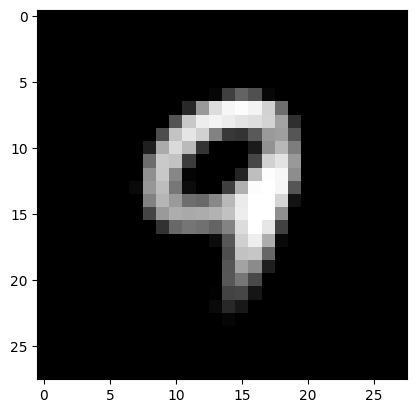

In [20]:
plt.imshow(med[9], cmap = "gray")

The classes are balanced so i will take a 10 percent of sampled as unclassifiable

In [21]:
for i in range(10):
    print(f"{i}: {len(labels[labels == i]) / len(labels)}")

0: 0.09861428571428571
1: 0.11252857142857142
2: 0.09985714285714285
3: 0.10201428571428571
4: 0.09748571428571429
5: 0.09018571428571429
6: 0.09822857142857143
7: 0.10418571428571428
8: 0.0975
9: 0.0994


In [22]:
from numpy.linalg import norm

def get_cosine_similarity(image, median_image):
     return np.dot(image.flatten(),median_image.flatten())/(norm(image.flatten())*norm(median_image.flatten()))

In [23]:
t_images = thresholding(images, 0.3)

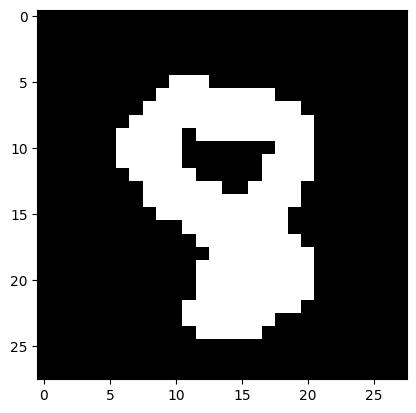

In [24]:
plt.imshow(t_images[3], cmap = "gray")

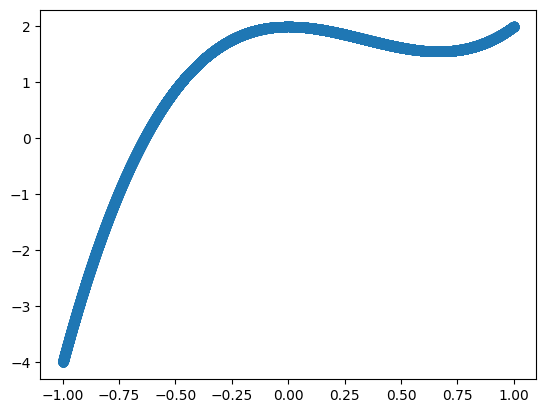

In [77]:
f = lambda x: 3*x**3 + -3*x**2 + 2
x = np.linspace(-1, 1, 100000)
plt.scatter(x, f(x))

In [78]:
#adding noise
noise = np.random.normal(0, 0.5, len(x))
y = f(x) + noise

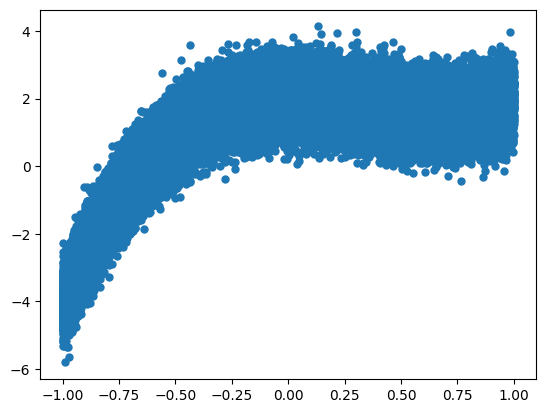

In [79]:
plt.scatter(x, y, linewidths=0.01)

In [136]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.fc(x)


In [137]:
model = MLP().to(device)
model

MLP(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [138]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(x), torch.from_numpy(y)), batch_size=32, shuffle=True)
example = next(iter(train_loader))
example

[tensor([ 0.1318,  0.2329, -0.4194,  0.8325, -0.0379,  0.7262, -0.9517, -0.8899,
          0.7552,  0.5605, -0.3160, -0.0970, -0.0399, -0.3509, -0.3652, -0.6862,
          0.7780,  0.1047,  0.6048,  0.3377,  0.6574, -0.6169, -0.5917, -0.2463,
          0.1978, -0.5994,  0.0710, -0.0382, -0.1459,  0.7848,  0.1254,  0.9543],
        dtype=torch.float64),
 tensor([ 2.2930,  1.9053,  0.3611,  1.6235,  2.0946,  1.8628, -3.4110, -2.6768,
          1.1574,  2.1500,  1.0990,  2.4666,  2.3200,  1.5900,  1.1210, -0.2660,
          1.7272,  2.0746,  1.8311,  1.4822,  1.8680, -0.1453,  0.0647,  1.2260,
          1.6778,  0.1195,  2.4499,  2.0013,  2.6071,  1.4272,  1.8853,  2.1946],
        dtype=torch.float64)]

In [139]:
def train(model, train_loader, epochs = 10):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for _ in tqdm(range(epochs)):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.unsqueeze(1).float())
            loss = criterion(output, target.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

In [142]:
start_time = time.time()
train(model, train_loader, 10)
print(f"--- {time.time() - start_time} seconds ---")

100%|██████████| 3/3 [00:08<00:00,  2.75s/it]

--- 8.251635551452637 seconds ---


torch.Size([100000, 16])


ValueError: x and y must be the same size

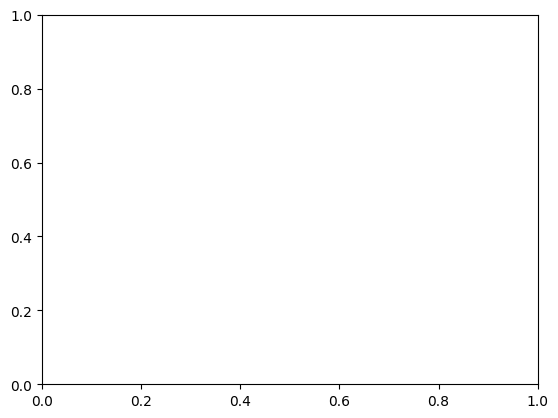

In [111]:
#evaluate model
model.eval()
with torch.no_grad():
    pred = model(torch.from_numpy(x).unsqueeze(1).float().to(device))
    print(pred.shape)
    plt.scatter(x, pred.cpu().numpy(), linewidths=0.01)